# Оценка объема стабильной части средств на расчетных счетах клиентов

**Задача:**  
На основании данных об объемах стабильной части средств на депозитных счетах клиентов построить модель, которая оценивает объем стабильной части средств на дату.

**Критерии:**
Минимизировать максимальный объем пробития стабильный части на валидационной выборке 

**План исследования:**
 1. Обзор данных 
 2. Анализ данных
 3. Обучение и тестирование моделей 
 4. Вывод

## 1. Обзор данных

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime

from matplotlib import dates

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

In [2]:
df = pd.read_csv('/Users/galina/Desktop/учёба/сбер виртуальная стажировка/Вспомогательные данные/data.csv',
                 sep=';',
                 parse_dates=[0])

In [3]:
df.columns = df.columns.str.lower()

In [4]:
df = df.sort_values(by='reportdate').reset_index(drop=True)

In [5]:
print('Начало таблицы:')
display(df.head())
print('-----------------------------------------------------------------')

print('Конец таблицы:')
display(df.tail())
print('-----------------------------------------------------------------')

print('Основная инфо:')
print(df.info())
print('-----------------------------------------------------------------')

print('Кол-во пропусков:')
print(df.isna().sum())

Начало таблицы:


,reportdate,value
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,4333581643
4,2014-01-03,5010720003


-----------------------------------------------------------------
Конец таблицы:


,reportdate,value
2106,2019-12-05,73555567407
2107,2019-12-06,74062556441
2108,2019-12-07,78228598454
2109,2019-12-08,76917198439
2110,2019-12-09,74105978838


-----------------------------------------------------------------
Основная инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   reportdate  2111 non-null   datetime64[ns]
 1   value       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB
None
-----------------------------------------------------------------
Кол-во пропусков:
reportdate    0
value         0
dtype: int64


### Вывод по п.1. Обзор данных:
 1. Данные с 30 декабря 2013 по 09 декабря 2019, всего 2 111 записей, почти 6 лет
 2. Пропусков нет, тип данных в VALUE менять не надо
 3. Дубликаты искать бессмысленно, так как объем остатков может повторяться

## 2. Анализ данных

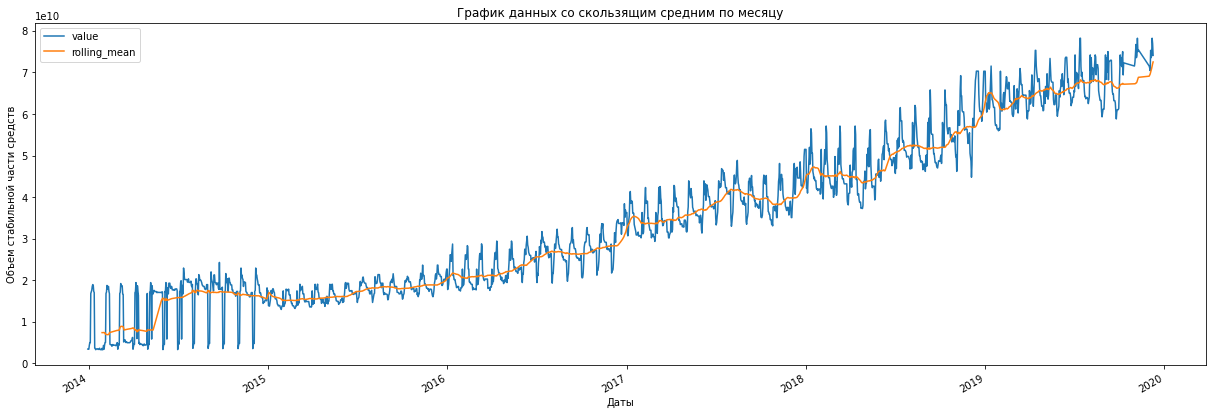

In [7]:
#график данных и скользящее среднее:

data = df.set_index('reportdate')

figsize = (21,7)

data['rolling_mean'] = data.rolling(30).mean()
data.plot(figsize=figsize)
plt.title('График данных со скользящим средним по месяцу')
plt.xlabel('Даты')
plt.ylabel('Объем стабильной части средств')
plt.show()

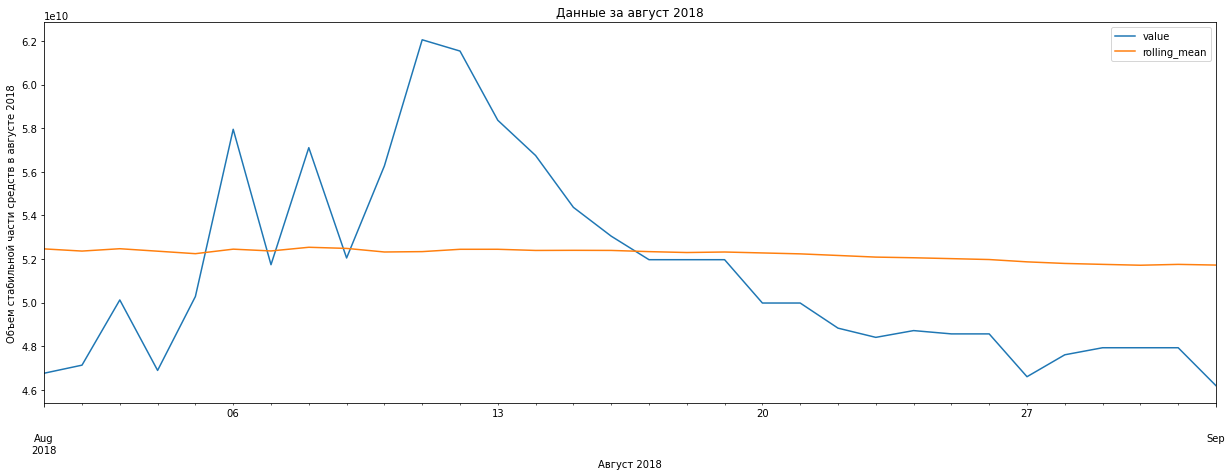

In [8]:
#данные за 1 месяц любого года
data_august_2018 = data['2018-08-01':'2018-09-01']
data_august_2018.plot(figsize=figsize)
plt.title('Данные за август 2018')
plt.xlabel('Август 2018')
plt.ylabel('Объем стабильной части средств в августе 2018')
plt.show()

Промежуточные выводы: очевиден рост объема стабильной части средств из года в год, то есть временной ряд чисто визуально не стационарен.

До июня 2014 и с октября 2019 на графиках есть участки, выбивающиеся из графика - резкие всплески и плато. Избавлюсь от них, так как они могут повлиять на точность работы модели.  

В разбивке по годам и по графику случайно взятого месяца видно, что стабильная часть средств на расчетных счетах резко повышается в районе 6, 8, 12 чисел каждого месяца. Видимо, это начисления авансов и зарплат.

In [9]:
#удаление участков с всплесками и плато
df = df[(df.reportdate >= '2014-07-01') & (df.reportdate <= '2019-09-30')].reset_index(drop=True)
data = data.loc['2014-07-01':'2019-09-30']

In [10]:
#тест Дики-Фуллера

test = sm.tsa.adfuller(data.value)

print('adf: ', test[0])
print('p-value: ', test[1])
print('Критические значения: ', test[4])
print()

if test[0] > test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен.')
else:
    print ('Единичных корней нет, ряд стационарен.')

adf:  0.4748055728517587
p-value:  0.9840868772755755
Критические значения:  {'1%': -3.433846147749841, '5%': -2.8630843523534826, '10%': -2.567592156824906}

Есть единичные корни, ряд не стационарен.


In [11]:
#тест Харке-Бера

row = [u'statistic', u'p-value', u'skewness', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data.value)
a = np.vstack([jb_test])
print(SimpleTable(a, row))

    statistic             p-value               skewness           kurtosis     
--------------------------------------------------------------------------------
139.98361779610147 4.0081467795839115e-31 0.47343331212341405 2.0663738888521173
--------------------------------------------------------------------------------


Промежуточный вывод: skewness (асимметрия) не равна нулю, kurtosis (эксцесс) не равен 3, то есть гипотеза о нормальности распределения также отвергается, ряд скорее всего стационарным не является

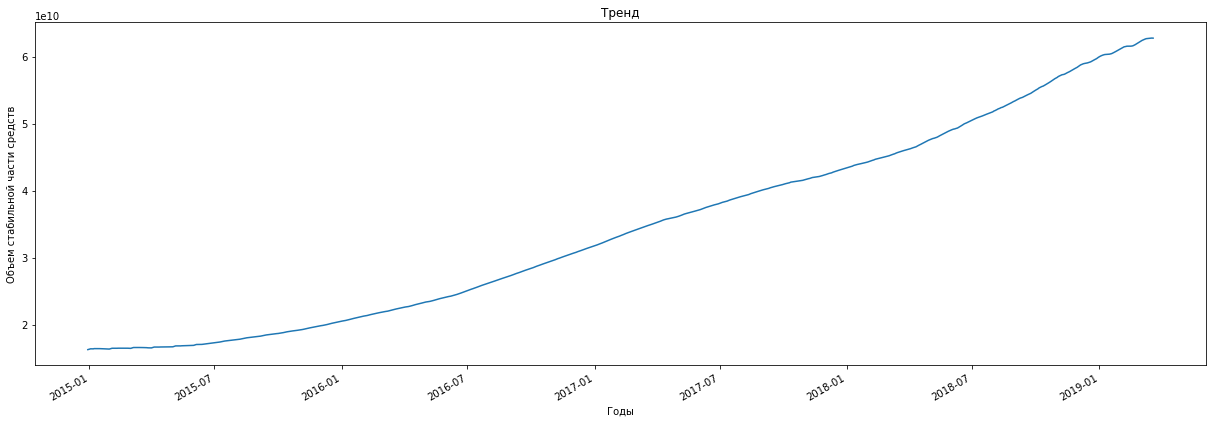

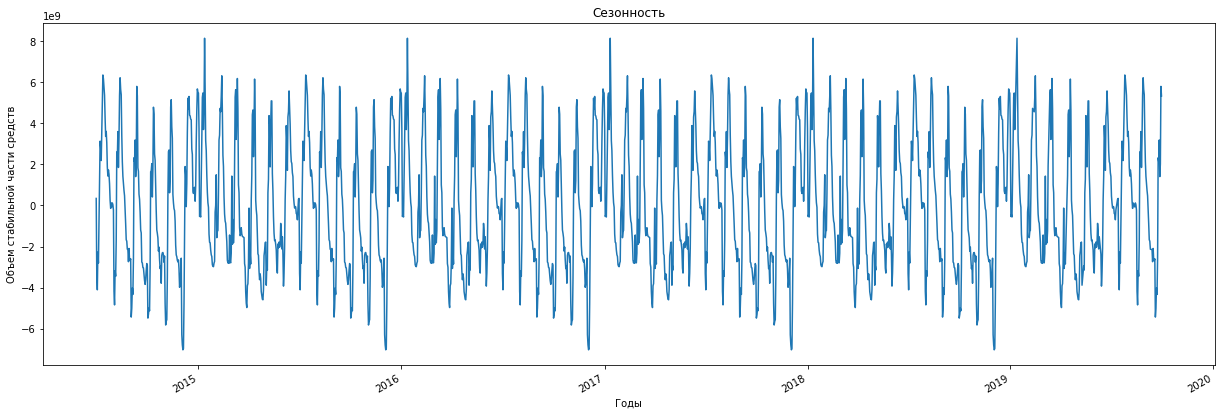

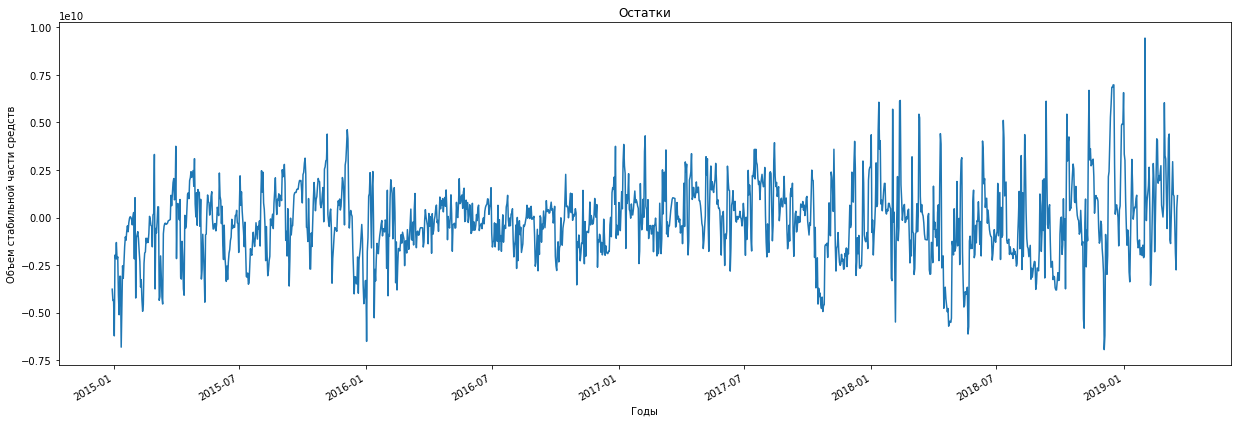

In [12]:
#тренд, сезонность и остатки

decomposed = seasonal_decompose(data.value, freq=365)

decomposed.trend.plot(figsize=figsize)
plt.title('Тренд')
plt.xlabel('Годы')
plt.ylabel('Объем стабильной части средств')
plt.show()

decomposed.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Годы')
plt.ylabel('Объем стабильной части средств')
plt.show()

decomposed.resid.plot(figsize=figsize)
plt.title('Остатки')
plt.xlabel('Годы')
plt.ylabel('Объем стабильной части средств')
plt.show()

### Вывод по п.2. Анализ данных:
1. График данных, а также тесты Дики-Фуллера и Харке-Бера показали, что ряд не стационарный.
2. Тренд идет на явное возрастание, на графике остатков видны всплески. Есть сезонность месячная с максимумом в районе 12 числа и годовая с максимумом в январе.
3. До июня 2014 и с октября 2019 были участки, выбивающиеся из графика, избавилась от них для лучшей работы моделей

## 3. Обучение и тестирование моделей 

In [13]:
#train = df.loc[:'2018-12-31'] 
#test = df.loc['2019-01-01':]

split = df[df.reportdate=='2019-01-01'].index[0]

train = df.head(split)
test = df.tail(len(df)-split)

In [31]:
#функция метрик и графиков моделей

def model_metrics_plots(data, title):
    
    rmse = mean_squared_error(data['value'].tail(len(df)-split),
                              data['forecast'].tail(len(df)-split),
                              squared=False)
    
    mae = mean_absolute_error(data['value'].tail(len(df)-split),
                              data['forecast'].tail(len(df)-split))
    
    
    data['penetration'] = data['forecast'].tail(len(df)-split).min() - data['value'].tail(len(df)-split)
    data['forecast_stable_part'] = data['forecast'].tail(len(df)-split).min()
    data['real_stable_part'] = data['value'].tail(len(df)-split).min()
    penetration = data.penetration[data.penetration > 0].sum()
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(2,1, 1)
    ax2 = fig.add_subplot(2,1, 2)
    
    data[['value','forecast']].head(split).plot(color=['black','green'],
                                                title='Модель ' + title,
                                                grid=True, ax=ax1)      
    ax1.set(xlabel='reportdate')
    
    
    data[['value','forecast', 'forecast_stable_part', 'real_stable_part']].tail(len(df)-split).\
    plot(color=['black','red', 'orange', 'green'],
         title='Прогноз на тестовой выборке',
         grid=True, ax=ax2)
    
    ax2.set(xlabel='reportdate')
    ax2.legend(loc='upper left')
    
    plt.show()

    print(f'MAE = {np.round(mae):_}'.replace("_", " "))
    print(f'RMSE = {np.round(rmse):_}'.replace("_", " "))
    print(f'Объем пробития прогнозной стабильной части = {penetration:_}'.replace("_", " "))

### SARIMAx

In [26]:
d = 1                              
D = 1                              
s = 30                             

In [27]:
sarima = SARIMAX(train.value, order=(1, d, 1), seasonal_order=(1, D, 1, s)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25729D+01    |proj g|=  7.19821D-02


 This problem is unconstrained.



At iterate    5    f=  2.25232D+01    |proj g|=  2.58092D-02

At iterate   10    f=  2.25113D+01    |proj g|=  1.08886D-02

At iterate   15    f=  2.25107D+01    |proj g|=  8.98883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   3.539D-05   2.251D+01
  F =   22.510670571887804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [28]:
df_sarima_test = test.copy()
df_sarima_test['forecast'] = sarima.predict(start=len(train), end=len(train)+len(test)-1, exog=None)

In [29]:
df_sarima_train = train.copy()
df_sarima_train['forecast'] = sarima.fittedvalues
df_sarima_train = df_sarima_train.append(df_sarima_test)

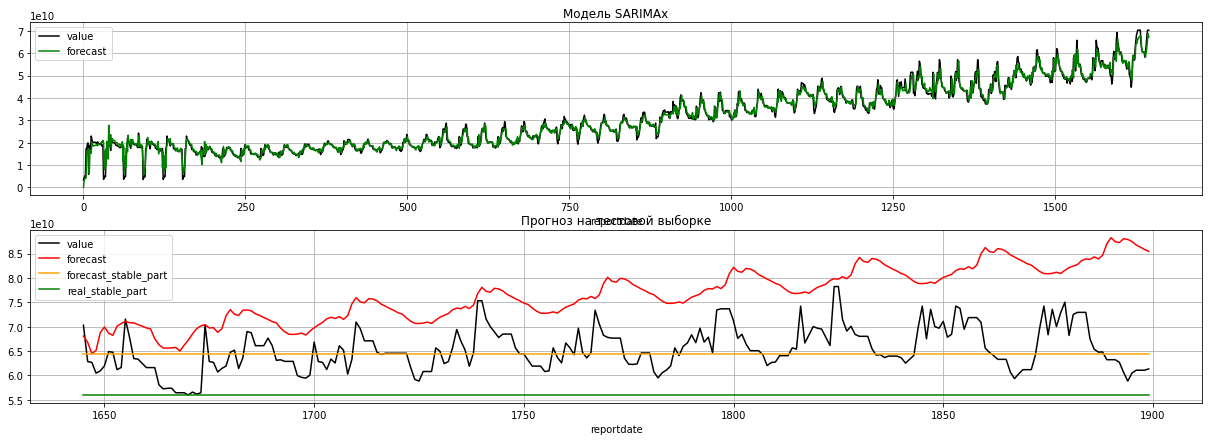

MAE = 11 206 913 273.0
RMSE = 12 532 286 982.0
Объем пробития прогнозной стабильной части = 326 393 269 034.9956


In [32]:
model_metrics_plots(df_sarima_train, title='SARIMAx')

### Prophet

In [20]:
prophet_train = train.rename(columns={'reportdate':'ds', 'value':'y'})
prophet_test = test.rename(columns={'reportdate':'ds', 'value':'y'})

In [21]:
prophet = Prophet(growth='linear',
                  changepoints=None, 
                  n_changepoints=365,
                  seasonality_mode='multiplicative',
                  yearly_seasonality='auto', 
                  weekly_seasonality='auto', 
                  daily_seasonality=False,
                  holidays=None)
prophet.add_country_holidays(country_name='RU')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=3)

prophet.fit(prophet_train)

13:26:58 - cmdstanpy - INFO - Chain [1] start processing
13:27:01 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
df_prophet = prophet.make_future_dataframe(periods=len(prophet_test), freq='D', include_history=True)
df_prophet = prophet.predict(df_prophet)

In [23]:
df_prophet_train = prophet_train.merge(df_prophet[['ds','yhat']]).rename(columns={'yhat':'forecast', 'y':'value'}).set_index('ds')

df_prophet_test = prophet_test.merge(df_prophet[['ds','yhat']]).rename(columns={'yhat':'forecast', 'y':'value'}).set_index('ds')

df_prophet_unit = df_prophet_train.append(df_prophet_test)

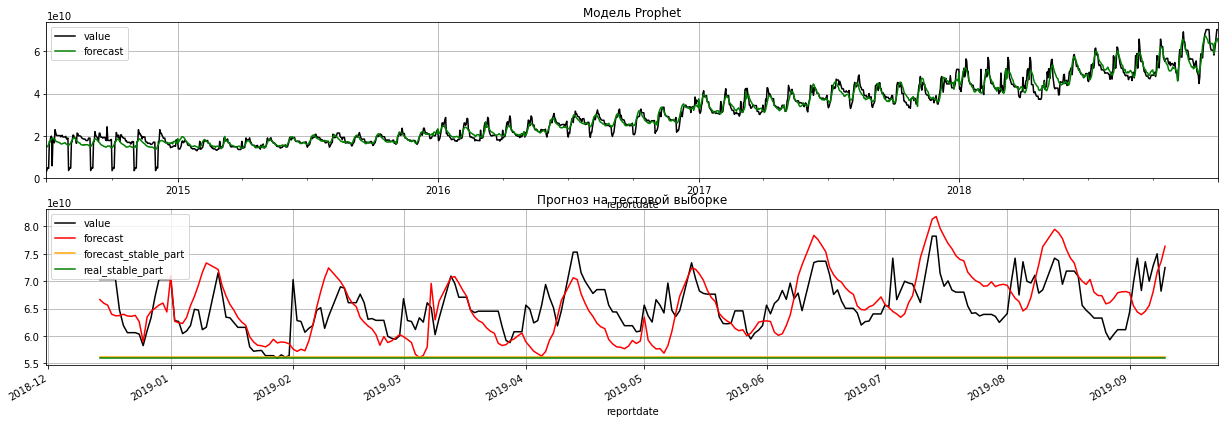

MAE = 3 799 946 090.0
RMSE = 4 632 124 258.0
Объем пробития прогнозной стабильной части = 115 269 928.93969727


In [33]:
model_metrics_plots(df_prophet_unit, title='Prophet')

## 4. Вывод
Из 2 моделей наиболее подходящяя для прогнозирования - Prophet, так как она дала меньшие значения MAE и RMSE.